# Import necessary liberaries

In [ ]:
%%bash

pip install pytube

pip3 -qqq install transformers[torch] torch datasets

pip3 -qqq install gdcm
pip3 -qqq install pydicom
pip -qqq install faiss-gpu
pip -qqq install pinecone-client
pip -qqq install scenedetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
import os
import faiss
import torch
import skimage
import pinecone
import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pytube import YouTube
from PIL import Image
from io import BytesIO
import IPython.display
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.decomposition import PCA
import time
import cv2

# Dataset

## Download dataset

In [ ]:
df = pd.read_csv('https://query.data.world/s/cagbol5yuk7ykt2sswer5vdcn5yxeg?dws=00000')

In [ ]:
df.head()

,video id,name,channel,category,views,likes,dislikes
0,cod_pLGV5GE,Maddox News - Crisis Actor Dipshit Conspiracy ...,Maddox,Comedy,"6,979",335,339.0
1,HhRg51O_gV4,Parkland Crisis Actor Conspiracy Theory DEBUNKED,The Young Turks,News & Politics,"165,530","3,407",2054.0
2,D6LddsrgqpM,CRISIS ACTOR EXPOSED!!! #TAMMYMUSTGO,The Daily Show with Trevor Noah,Comedy,"439,905","12,283",495.0
3,kSh4jYUlzO4,Milo And Alex Jones Digging In Florida Situati...,OpenMind,News & Politics,"5,129",165,7.0
4,notEwvNsaqc,ALEX in STUDIO W/ MILO: CRISIS ACTORS! - ALEX ...,INFO WARS NEWS,Entertainment,"15,159",585,96.0


In [ ]:
len(df)

8823

In [ ]:
df_small = df[:200]

In [ ]:
len(df_small)

200

If you run YouTube downeloader you will get this error:
```AttributeError: 'NoneType' object has no attribute 'span'```

I just patched this error by simply modifying {home}/.local/lib/python3.7/site-packages/pytube/cipher.py
Line 411

```transform_plan_raw = find_object_from_startpoint(raw_code, match.span()[1] - 1)
to```

```transform_plan_raw = js```
And everything works fine.
Hope this can solve your problem.

In [ ]:
def check_valid_URLs(video_id):
  checker_url = "https://www.youtube.com/oembed?url=http://www.youtube.com/watch?v="
  video_url = checker_url + video_id

  request = requests.get(video_url)
  if request.status_code == 200:
    return True
  else:
    return False
def download_video(video_id):

  # where to save
  SAVE_PATH = "/content/videos/" #to_do

  # link of the video to be downloaded
  link = f"https://www.youtube.com/watch?v={video_id}"

  try:
    # object creation using YouTube
    yt = YouTube(link)
    # Get all streams and filter for mp4 files
    mp4_streams = yt.streams.filter(progressive=True, file_extension='mp4').order_by(
        'resolution').desc().first()


    # downloading the video
    mp4_streams.download(output_path=SAVE_PATH)
    output = 'Video downloaded successfully!'
    return output
  except:
    output = "Some Error!"
    return output

In [ ]:
import os
def my_mkdirs(folder):
  if os.path.exists(folder)==False:
    os.makedirs(folder)
my_mkdirs('/content/videos/')

In [ ]:
valid_urls = []
count = len(df_small['video id'])
i = 0
for id in df_small['video id']:
  validation = check_valid_URLs(id)
  print(f'validation of {i} url in dataframe is: {validation}')
  valid_urls.append(validation)
  i += 1
  if i == count:
    break

validation of 0 url in dataframe is: True
validation of 1 url in dataframe is: True
validation of 2 url in dataframe is: True
validation of 3 url in dataframe is: False
validation of 4 url in dataframe is: False
validation of 5 url in dataframe is: True
validation of 6 url in dataframe is: False
validation of 7 url in dataframe is: True
validation of 8 url in dataframe is: True
validation of 9 url in dataframe is: False
validation of 10 url in dataframe is: True
validation of 11 url in dataframe is: False
validation of 12 url in dataframe is: True
validation of 13 url in dataframe is: False
validation of 14 url in dataframe is: False
validation of 15 url in dataframe is: True
validation of 16 url in dataframe is: False
validation of 17 url in dataframe is: False
validation of 18 url in dataframe is: True
validation of 19 url in dataframe is: False
validation of 20 url in dataframe is: False
validation of 21 url in dataframe is: False
validation of 22 url in dataframe is: True
validatio

In [ ]:
df_small['is_valid'] = valid_urls

<ipython-input-11-1e2ef609192f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['is_valid'] = valid_urls


In [ ]:
df_small = df_small[df_small['is_valid'] == True]

In [ ]:
len(df_small)

31

In [ ]:
df_small.reset_index(drop=True, inplace=True)

In [ ]:
df_small.head()

,video id,name,channel,category,views,likes,dislikes,is_valid
0,cod_pLGV5GE,Maddox News - Crisis Actor Dipshit Conspiracy ...,Maddox,Comedy,"6,979",335,339.0,True
1,HhRg51O_gV4,Parkland Crisis Actor Conspiracy Theory DEBUNKED,The Young Turks,News & Politics,"165,530","3,407",2054.0,True
2,D6LddsrgqpM,CRISIS ACTOR EXPOSED!!! #TAMMYMUSTGO,The Daily Show with Trevor Noah,Comedy,"439,905","12,283",495.0,True
3,aWu1EoBgMyU,The Problem With YouTube Crisis Actors - YouTu...,CrimsonStudios,Comedy,"1,310",174,19.0,True
4,DL3omF0JpZs,Should We Address Crisis Actor False Flag Cons...,David Pakman Show,News & Politics,"23,926",854,42.0,True


In [ ]:
valid_video = []
for id in df_small['video id']:
  output = download_video(id)
  if output == "Some Error!":
    valid_video.append(False)
  else:
    valid_video.append(True)
  print(output)

Video downloaded successfully!
Video downloaded successfully!
Some Error!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!
Video downloaded successfully!


In [ ]:
df_small['valid_video'] = valid_video

In [ ]:
df_small = df_small[df_small['valid_video'] == True]

In [ ]:
df_small.reset_index(drop=True, inplace=True)

get file names for videeos in videos folder

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = "/content/videos/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
onlyfiles

['What are Crisis Actors  Stuff They Dont Want You to Know.mp4',
 'CBSLA Interviews Parkland Shooting Survivor David Hogg.mp4',
 'The Problem With YouTube Crisis Actors - YouTube Messed Up.mp4',
 'Crisis Actor - Tor.mp4',
 'Crisis actors False Flags.mp4',
 'When Your Tragedy is Called a Hoax and Youre Labeled Crisis Actors  After Truth.mp4',
 'The Kids From Florida Arent Acting.mp4',
 'David Hogg On Crisis Actor Conspiracies Change Is Coming Regardless  Andrea Mitchell  MSNBC.mp4',
 'Conspiracy Theory Claims Parkland Survivor A ‘Crisis Actor’  NBC Nightly News.mp4',
 'Should We Address Crisis Actor False Flag Conspiracy Theories.mp4',
 'Lemon Demon - Crisis Actors (2016).mp4',
 'EXPOSED School Shooting Survivor Turned Activist David Hogg’s Father in FBI Appears To Have Been.mp4',
 'School shooting survivors demand action on gun control.mp4',
 'YouTube controversy persists over false conspiracy video about David Hogg.mp4',
 'Crisis Actor - Rape Crisis Actor.mp4',
 'Crisis Actor at Nebul

# Get model and all reqoured preprocessing functions

In [ ]:
def get_model_info(model_ID, device):
  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)
   # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)
  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  return model, processor, tokenizer

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_ID = 'openai/clip-vit-base-patch32'
model, processor, tokenizer = get_model_info(model_ID, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Phase 1: Visual search

## Extract embbedings from videos

In [ ]:
def extract_embedding_from_video(video_path):
  frames = []
  cap = cv2.VideoCapture(video_path)
  frame_rate = cap.get(cv2.CAP_PROP_FPS)
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  total_seconds = total_frames / frame_rate
  target_frame_count = int(total_seconds)
  target_frame_index = 0
  for i in range(target_frame_count):
      cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
      ret, frame = cap.read()
      # frame = cv2.resize(frame, (1280, 720))
      frame = cv2.resize(frame, (224, 224))
      if not ret:
          break
      frames.append(frame)
      target_frame_index += int(frame_rate)
  cap.release()

  embeddings = []
  for frame in frames:
    image = processor(
      text=None,
      images = frame,
      return_tensors='pt',
    )['pixel_values'].to(device)
    embedding = model.get_image_features(image)
    embedding_as_np = embedding.cpu().detach().numpy()
    embeddings.append(list(np.squeeze(embedding_as_np)))
  embeddings = np.asarray(embeddings)

  return np.mean(embeddings, axis=0)

In [ ]:
from tqdm.notebook import tqdm
def extract_all_embedding(video_names):
  embeddings = []
  for i in tqdm(range(len(onlyfiles))):
    file_name = onlyfiles[i]
    video_path = f"/content/videos/{file_name}"
    embedding = extract_embedding_from_video(video_path)
    embeddings.append(embedding)
  return embeddings

In [ ]:
embeddings = tqdm(extract_all_embedding(onlyfiles))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

## Extract embedding from text

In [ ]:
embeddings_list = []
for embedding in embeddings:
  embeddings_list.append(embedding)

NameError: name 'embeddings' is not defined

In [ ]:
def get_single_text_embedding(text):
  inputs = tokenizer(text, return_tensors='pt').to(device)
  text_embeddings = model.get_text_features(**inputs)
  # Convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return np.squeeze(embedding_as_np)

In [ ]:
def get_all_text_embeddings(df, text_col):
  df['text_embeddings'] = df[str(text_col)].apply(get_single_text_embedding)

  return df

In [ ]:
df_small = get_all_text_embeddings(df_small, 'name')

In [ ]:
df_small.head()

,video id,name,channel,category,views,likes,dislikes,is_valid,valid_video,text_embeddings
0,cod_pLGV5GE,Maddox News - Crisis Actor Dipshit Conspiracy ...,Maddox,Comedy,"6,979",335,339.0,True,True,"[0.17809792, -0.16444528, 0.11406559, -0.04545..."
1,HhRg51O_gV4,Parkland Crisis Actor Conspiracy Theory DEBUNKED,The Young Turks,News & Politics,"165,530","3,407",2054.0,True,True,"[-0.11369254, -0.014832489, 0.041477025, 0.024..."
2,aWu1EoBgMyU,The Problem With YouTube Crisis Actors - YouTu...,CrimsonStudios,Comedy,"1,310",174,19.0,True,True,"[0.32304192, -0.26634318, -0.0040990636, 0.084..."
3,DL3omF0JpZs,Should We Address Crisis Actor False Flag Cons...,David Pakman Show,News & Politics,"23,926",854,42.0,True,True,"[-0.11956087, -0.12763253, 0.11223187, 0.21075..."
4,9CVZr0lIgv8,David Hogg On Crisis Actor Conspiracies: Cha...,MSNBC,News & Politics,"63,364",815,774.0,True,True,"[0.5864887, -0.6514987, -0.07040526, -0.079586..."


## Dimension reduction using PCA

In [ ]:
# n_components = min(random_number, num_images, len(features))
n_components = min(100, len(df_small), len(df_small['text_embeddings'][0]))

<ipython-input-48-9b64122ca1b0>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


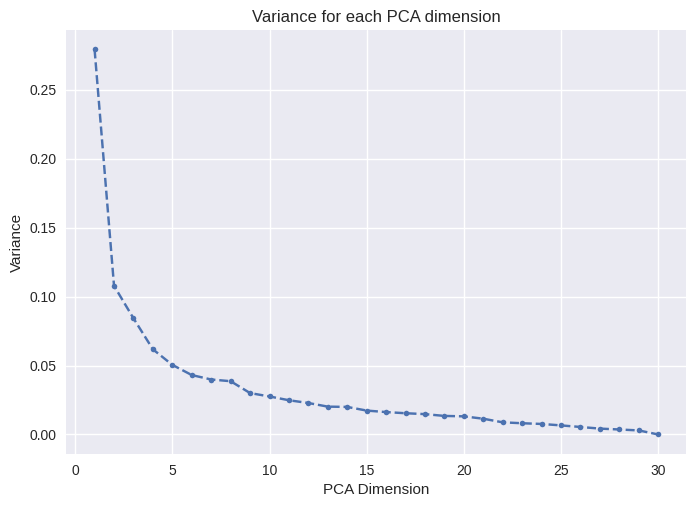

In [ ]:
# Check trade-off between num-dimensions and variance
pca = PCA(n_components)
pca.fit(list(df_small['text_embeddings']))
matplotlib.style.use('seaborn')
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, 'o--', markersize=4)
plt.title('Variance for each PCA dimension')
plt.xlabel('PCA Dimension')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [ ]:
# Number of features for tex-image search after dimension reduction
num_feature_dimensions = 30

In [ ]:
df_small['text_embeddings'].shape

(30,)

In [ ]:
# Apply dimention reduction on text_embedding using PCA
pca = PCA(n_components=num_feature_dimensions)
pca.fit(list(df_small['text_embeddings']))
text_embedding_compressed = pca.transform(list(df_small['text_embeddings']))
text_embedding_compressed = text_embedding_compressed.tolist()

In [ ]:
len(text_embedding_compressed), len(text_embedding_compressed[0])

(30, 30)

In [ ]:
video_embeddings_compressed = pca.transform(embeddings_list)
video_embeddings_compressed = video_embeddings_compressed.tolist()

In [ ]:
len(video_embeddings_compressed), len(video_embeddings_compressed[0])

(30, 30)

In [ ]:
df_small['video_embeddings_compressed'] = video_embeddings_compressed

NameError: name 'video_embeddings_compressed' is not defined

In [ ]:
df_small['text_embeddings_compressed'] = text_embedding_compressed

## Pinecone

In [ ]:
from pinecone import Pinecone, ServerlessSpec

In [ ]:
API_KEY = 'f58afe0a-3959-4cb0-9020-f5d06db8ef14'

In [ ]:
pc = Pinecone(api_key=API_KEY)

In [ ]:
import os
CLOUD = os.environ.get('PINECONE_CLOUD') or 'aws'
REGION = os.environ.get('PINECONE_REGION') or 'us-east-1'

SPEC = ServerlessSpec(cloud=CLOUD, region=REGION)

In [ ]:
# Create a severless index
import time

INDEX_NAME = "tex-video"

existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if INDEX_NAME not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        INDEX_NAME,
        dimension=num_feature_dimensions,  # dimensionality of minilm
        metric='cosine',
        spec=SPEC
    )
    # wait for index to be initialized
    while not pc.describe_index(INDEX_NAME).status['ready']:
        time.sleep(1)

# connect to index
my_index = pc.Index(INDEX_NAME)
time.sleep(1)
# view index stats
my_index.describe_index_stats()

{'dimension': 30,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 30}},
 'total_vector_count': 30}

In [ ]:
df_small['vector_id'] = df_small.index
df_small['vector_id'] = df_small['vector_id'].apply(str)

In [ ]:
# Get all the metadata
final_metadata = []
for index in range(len(df_small)):
  final_metadata.append({
      'ID': index,
      'caption': df_small.iloc[index]['name'],
      'image': df_small.iloc[index]['video id']
  })

video_embeddings_compressed_IDs = df_small.vector_id.tolist()
video_embeddings = [arr for arr in df_small.video_embeddings_compressed]
# Create the single list of directory format to insert
# data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

In [ ]:
vectors = [
    {'id': id,
    'values': values,
    'metadata': metadata} for id, values, metadata in zip(image_IDs, video_embeddings, final_metadata)
]

In [ ]:
my_index.upsert(vectors=vectors)

{'upserted_count': 30}

In [ ]:
# Check index size for each namespace
my_index.describe_index_stats()

{'dimension': 30,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 30}},
 'total_vector_count': 30}

In [ ]:
def pinecone_quey(text):
  query_embedding = get_single_text_embedding(text)
  compressed_text = pca.transform(np.expand_dims(query_embedding, axis=0))
  squeezed_text = np.squeeze(compressed_text).tolist()
  my_index.query(vector=squeezed_text, top_k=4, include_metadata=True)


In [ ]:
# Get the query text
text_query = df_small.iloc[10]['name']

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query)


In [ ]:
np.expand_dims(query_embedding, axis=0).shape

(1, 512)

In [ ]:
# Get the query text
text_query = df_small.iloc[10]['name']

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query)

# Reduce the dimension
compressed_text = pca.transform(np.expand_dims(query_embedding, axis=0))

# Squeeze embedding
squeezed_text = np.squeeze(compressed_text).tolist()

In [ ]:
squeezed_text

[-0.6582945366177111,
 -1.6623512014728687,
 0.09286934626694322,
 3.1269233030353325,
 0.8189004809932847,
 -0.4841784888530363,
 -0.5106306774193698,
 -0.43382837314283257,
 -1.5864654262570856,
 -1.0030705235619666,
 -1.734997147470491,
 -0.7708424554542436,
 0.0967970872779975,
 0.6502997194586113,
 -0.38818964892956814,
 1.1059231686899142,
 -1.1285410605746464,
 0.7869997933866176,
 -0.04204867564529004,
 0.27326851632802285,
 -0.08390044131040036,
 0.03669212456122614,
 0.04400114609464833,
 -0.12134063242934896,
 -0.32091615374798516,
 -0.20553225390519095,
 -0.04001314116732292,
 0.01029824012491776,
 -0.003695576992737762,
 7.203439233993691e-16]

In [ ]:
matches = my_index.query(vector=squeezed_text, top_k=4, include_metadata=True)

In [ ]:
len(matches['matches'])

4

In [ ]:
matches

{'matches': [{'id': '15',
              'metadata': {'ID': 15.0,
                           'caption': 'Crisis Actor - Tor',
                           'image': 'jLFcQ1y8pU0'},
              'score': -0.115118958,
              'values': []},
             {'id': '19',
              'metadata': {'ID': 19.0,
                           'caption': '#MorningMonarchy: Donald Trump  Crisis '
                                      'Actor?',
                           'image': 'nqPAFBHyWD8'},
              'score': -0.126400888,
              'values': []},
             {'id': '3',
              'metadata': {'ID': 3.0,
                           'caption': 'Should We Address Crisis Actor False '
                                      'Flag Conspiracy Theories?',
                           'image': 'DL3omF0JpZs'},
              'score': -0.149269477,
              'values': []},
             {'id': '8',
              'metadata': {'ID': 8.0,
                           'caption': 'What are  Crisis A

# Phase 2: Text search

In [ ]:
!pip install elasticsearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.0/478.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
from elasticsearch import Elasticsearch
from datetime import datetime

cloud_id = "Test_in_Python:ZWFzdHVzMi5henVyZS5lbGFzdGljLWNsb3VkLmNvbTo0NDMkYmUwNzcyNzAwMWY5NDA4MGFhZTFhYWRjYjJmODcwMWEkZWVmNDlkNTRjMTAxNDI5MDlhYjA2OGVmNTA1NGY1MzE="
api_key = "N2ZLcDU0OEJfekFzMDkzOWRsclE6VjZYdkhRRVBSYldCMEpCVGRuZFJDQQ=="

client = Elasticsearch(cloud_id=cloud_id, api_key=api_key)

In [ ]:
print(client.info())

{'name': 'instance-0000000001', 'cluster_name': 'be07727001f94080aae1aadcb2f8701a', 'cluster_uuid': 'fVkGp19bTfuDugRaUJwH1g', 'version': {'number': '8.13.4', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'da95df118650b55a500dcc181889ac35c6d8da7c', 'build_date': '2024-05-06T22:04:45.107454559Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [ ]:
from elasticsearch import helpers

def gendata():
  for i in range(len(df_small)):
    yield {
        "_index": "videos",
        "video_id": df_small.iloc[i]["video id"],
        "name": df_small.iloc[i]["name"],
        "channel": df_small.iloc[i]["channel"],
        "category": df_small.iloc[i]["category"]
    }

helpers.bulk(client, gendata())

(30, [])

# Phase 3: Serving

In [ ]:
def pretty_elastic(response):
  outputs = []
  if len(response["hits"]["hits"]) == 0:
    print("Your search returned no results")
  else:
    for hit in response["hits"]["hits"]:
      id = hit["_id"]
      score = hit["_score"]
      video_id = hit["_source"]["video_id"]
      name = hit["_source"]["name"]
      channel = hit["_source"]["channel"]
      category = hit["_source"]["category"]
      pretty_elastic_output = f"\nID: {id}\nVideo ID: {video_id}\nName: {name}\nChannel: {channel}\nCategory: {category}\nScore: {score}"
      outputs.append(pretty_elastic_output)
  return outputs

In [ ]:
def elastic_query(text):
  response = client.search(
      index="videos",
      query={
        "bool": {
          "must": [
            {
              "match": {
                "name": {
                  "query": text,
                  "fuzziness": "auto"
                }
              }
            }
          ],
          "should": [
            {
              "match": {
                "channel": {
                  "query": text,
                  "fuzziness": "auto"
                }
              }
            },
            {
              "match": {
                "category": {
                  "query": text,
                  "fuzziness": "auto"
                }
              }
            }
          ]
        }
      }
  )

  elastic_output = pretty_elastic(response)
  return elastic_output

In [ ]:
elastic_output = elastic_query("actors are in studio")

In [ ]:
for output in elastic_output:
  print(output)


ID: Ntdd7I8BE7xkNF2TjFss
Video ID: B2h-Of4QvSk
Name: What are  Crisis Actors?  | Stuff They Don t Want You to Know
Channel: Stuff They Don t Want You To Know - HowStuffWorks
Category: Entertainment
Score: 2.5473802

ID: Sddd7I8BE7xkNF2TjFss
Video ID: CyEcgeuc2Zo
Name: Adventures in Atrocity Propaganda
Channel: Alexandra Bruce
Category: Entertainment
Score: 2.1911335

ID: N9dd7I8BE7xkNF2TjFss
Video ID: 7wHf_wu69q0
Name: Crisis actors? False Flags?
Channel: Sage Wanderer
Category: Autos & Vehicles
Score: 2.0905285

ID: R9dd7I8BE7xkNF2TjFss
Video ID: Uu9ox9CPpMg
Name: The Kids From Florida Aren t Acting
Channel: The Late Show with Stephen Colbert
Category: Entertainment
Score: 1.730262

ID: Otdd7I8BE7xkNF2TjFss
Video ID: lrK0-FWezyg
Name: When Your Tragedy is Called a Hoax and You re Labeled Crisis Actors | After Truth
Channel: NBC Left Field
Category: News & Politics
Score: 1.3511181

ID: SNdd7I8BE7xkNF2TjFss
Video ID: NHyiW1eQAbM
Name: EXPOSED: School Shooting Survivor Turned Activist 

In [ ]:
def pretty_pinecone(matches):
  output = []
  if len(matches['matches']) == 0:
    print("Your search returned no result!")
  else:
    for item in matches['matches']:
      video_id = item['metadata']['image']
      caption = item['metadata']['caption']
      score = item['score']
      id = item['metadata']['ID']
      pretty_pinecone_output = f"\nID: {id}\nVideo_ID: {video_id}\nCaption: {caption}\nScore: {score}"
      output.append(pretty_pinecone_output)
  return output

In [ ]:
def pinecone_query(text):
  query_embedding = get_single_text_embedding(text)
  compressed_text = pca.transform(np.expand_dims(query_embedding, axis=0))
  squeezed_text = np.squeeze(compressed_text).tolist()
  matches = my_index.query(vector=squeezed_text, top_k=10, include_metadata=True)
  pinecone_output = pretty_pinecone(matches)
  return pinecone_output


In [ ]:
pinecone_output = pinecone_query("actors are in studio")

In [ ]:
for output in pinecone_output:
  print(output)


ID: 23.0
Video_ID: 2znXfkdQtbA
Caption: Crisis Actor at Nebulae
Score: -0.16308707

ID: 13.0
Video_ID: trd_W23NEyA
Caption: Confirmed David Hogg is NOT a crisis actor
Score: -0.194144741

ID: 0.0
Video_ID: cod_pLGV5GE
Caption: Maddox News - Crisis Actor Dipshit Conspiracy - Violent Video Game Ban - Robot Bullies
Score: -0.202367768

ID: 19.0
Video_ID: nqPAFBHyWD8
Caption: #MorningMonarchy: Donald Trump  Crisis Actor?
Score: -0.206552222

ID: 15.0
Video_ID: jLFcQ1y8pU0
Caption: Crisis Actor - Tor
Score: -0.213504851

ID: 7.0
Video_ID: 3i97DdqgwX4
Caption: CBSLA Interviews Parkland Shooting Survivor David Hogg
Score: -0.215038985

ID: 11.0
Video_ID: Sr1oyK5lvqQ
Caption: School shooting survivors demand action on gun control
Score: -0.245261565

ID: 8.0
Video_ID: B2h-Of4QvSk
Caption: What are  Crisis Actors?  | Stuff They Don t Want You to Know
Score: -0.247232348

ID: 22.0
Video_ID: eypbpgMgpWM
Caption: Lemon Demon - Crisis Actors (2016)
Score: -0.250281543

ID: 4.0
Video_ID: 9CVZr0lIgv

In [ ]:
def fusing_answers(text):
  elastic_output = elastic_query(text)
  pinecone_output = pinecone_query(text)
  for i, item in enumerate(zip(pinecone_output, elastic_output)):
    print(
        f"Number {i} Pinecone match: {item[0]}\n\nNumber {i} Elastic match: {item[1]}"
    )

In [ ]:
fusing_answers("crisis and cratus studio")

Number 0 Pinecone match: 
ID: 23.0
Video_ID: 2znXfkdQtbA
Caption: Crisis Actor at Nebulae
Score: 0.180618569

Number 0 Elastic match: 
ID: Otdd7I8BE7xkNF2TjFss
Video ID: lrK0-FWezyg
Name: When Your Tragedy is Called a Hoax and You re Labeled Crisis Actors | After Truth
Channel: NBC Left Field
Category: News & Politics
Score: 2.0579305
Number 1 Pinecone match: 
ID: 10.0
Video_ID: n-J-VS-588I
Caption: Republican Fired After Calling Victims Actors
Score: 0.173519686

Number 1 Elastic match: 
ID: S9dd7I8BE7xkNF2TjFss
Video ID: VaUlUbVgsWo
Name: Crisis Actor - Rape Crisis Actor
Channel: Black Harvest
Category: People & Blogs
Score: 0.68738043
Number 2 Pinecone match: 
ID: 13.0
Video_ID: trd_W23NEyA
Caption: Confirmed David Hogg is NOT a crisis actor
Score: 0.131850034

Number 2 Elastic match: 
ID: Pddd7I8BE7xkNF2TjFss
Video ID: jLFcQ1y8pU0
Name: Crisis Actor - Tor
Channel: Sanary Twink
Category: Music
Score: 0.60018754
Number 3 Pinecone match: 
ID: 7.0
Video_ID: 3i97DdqgwX4
Caption: CBSLA I